In [1]:
import torch
import sys
import os
import time
import numpy as np
import argparse
sys.path.append("..")

from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from umap.umap_ import find_ab_params

from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import VisModel
from singleVis.losses import UmapLoss, ReconstructionLoss, SingleVisLoss
from singleVis.edge_dataset import DataHandler
from singleVis.trainer import SingleVisTrainer
from singleVis.data import NormalDataProvider
from singleVis.spatial_edge_constructor import kcSpatialAlignmentEdgeConstructor
# from singleVis.temporal_edge_constructor import GlobalTemporalEdgeConstructor
from singleVis.alignment_edge_constructor import LocalAlignmentEdgeConstructor
from singleVis.projector import TimeVisProjector
from singleVis.eval.evaluator import Evaluator


import torch
import numpy as np
from CKA import CKA, CudaCKA

# REF_PATH : reference dataset path
# CONFUSION_PATH : benchmark1
# EXCHANGE_PATH : benchmark2

REF_PATH = "/home/yifan/dataset/noisy/pairflip/cifar10/noisy0.001"
CLEAN_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"

CONFUSION_PATH = "/home/yifan/dataset/confusion/pairflip/cifar10/0"
EXCHANGE_PATH = "/home/yifan/dataset/exchange/pairflip/cifar10/0"

sys.path.append(REF_PATH)


from config import config

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
PREPROCESS = VISUALIZATION_PARAMETER["PREPROCESS"]
LAMBDA = VISUALIZATION_PARAMETER["LAMBDA"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
INIT_NUM = VISUALIZATION_PARAMETER["INIT_NUM"]
ALPHA = VISUALIZATION_PARAMETER["ALPHA"]
BETA = VISUALIZATION_PARAMETER["BETA"]
MAX_HAUSDORFF = VISUALIZATION_PARAMETER["MAX_HAUSDORFF"]
# HIDDEN_LAYER = VISUALIZATION_PARAMETER["HIDDEN_LAYER"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
T_N_EPOCHS = VISUALIZATION_PARAMETER["T_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = 'vis'
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

SEGMENTS = [(EPOCH_START, EPOCH_END)]
# define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))


ref_provider = NormalDataProvider(REF_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)
clean_provider = NormalDataProvider(CLEAN_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)

confusion_provider = NormalDataProvider(CONFUSION_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)

exchange_provider = NormalDataProvider(EXCHANGE_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)


ref_train_data = ref_provider.train_representation(200).squeeze()

confusion_data = confusion_provider.train_representation(200).squeeze()

exchange_data = exchange_provider.train_representation(200).squeeze()

clean_data = clean_provider.train_representation(200).squeeze()

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Finish initialization...
Finish initialization...
Finish initialization...
Finish initialization...


In [3]:
#### data processer for exchange # rebuild the reference

import json
import os
import numpy as np
clean_path = os.path.join(EXCHANGE_PATH, 'clean_label.json')
with open(clean_path, "r") as f:
    clean_labels = np.array(json.load(f))
noisy_path = os.path.join(EXCHANGE_PATH, 'noisy_label.json')
with open(noisy_path, "r") as f:
    noisy_labels = np.array(json.load(f))
noisy_indicates = []
clean_indicates = []
label3_indicates = []
label2_indicates = []
pairs = []
for i in range(len(clean_labels)):
    if clean_labels[i] == 1:
        label2_indicates.append(i)
    if clean_labels[i] == 8:
        label3_indicates.append(i)

    # if clean_labels[i] != noisy_labels[i]:
    #     noisy_indicates.append(i)
    #     pairs.append({"clean":clean_labels[i],"noisy:": noisy_labels[i]})
    # else:
    #     clean_indicates.append(i)
# print(label2_indicates)




In [4]:

# print(label2_indicates)
import copy

ref_train_data = ref_provider.train_representation(200).squeeze()
for m in range(len(label2_indicates)):
    # print(m)
    index2 = label2_indicates[m]
    index3 = label3_indicates[m]

    temp = copy.deepcopy(ref_train_data[index2])
    # print(index2,index3)
    ref_train_data[index2] = copy.deepcopy(ref_train_data[index3])
    ref_train_data[index3] = temp
    # ref_train_data[index3] = temp

###  ============================= caculate cca ============================== ###
import numpy as np
from sklearn.cross_decomposition import CCA
# 建立模型
X = ref_train_data
Y = ref_provider.train_representation(200).squeeze()
cca = CCA(n_components=1)
# 训练数据
cca.fit(X, Y)
# print(X)
X_train_r, Y_train_r = cca.transform(X, Y)
# print(X_train_r)
print('Xj vs XjR ')
print(np.corrcoef(X_train_r[:, 0], Y_train_r[:, 0])[0, 1]) #输出相关系数   


#     if m 
#     print(exchange_data[m])

Xj vs XjR 
0.9961222500616329


In [7]:
from torch import nn
from torch.autograd import Variable

import torch.nn.functional as F
import scipy
import numpy as np
from sklearn.cross_decomposition import CCA

model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

# Step2: Computing the loss 
def compute_gradient(X, Y, R):
    '''
        the gradient of the loss with respect to the matrix encodes how much a tiny change 
    in some coordinate of that matrix affect the change of loss function.
        Gradient descent uses that information to iteratively change matrix R until we reach 
    a point where the loss is minimized.
    Inputs: 
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        R: a matrix of dimension (n,n) - transformation matrix from Y2d to X2d
    Outputs:
       g: a matrix of dimension (n,n) - gradient of the loss function L for given X, Y and R.
    '''
    # m is the number of rows in X
    m = len(X)

    rows, columns = X.shape

    gradient = (np.dot(X.T, np.dot(X, R) - Y) * 2)/rows
    assert gradient.shape == (columns, columns)
    ### END CODE HERE ###
    return gradient

def cauculate(X,Y,R):
    m = len(X)
    Y_2d = projector.batch_project(200, Y)
    X_2d = projector.batch_project(200, np.dot(X, R))


    Euclid = 0
    for i in range(m):
        d = ((X_2d[i][0] - Y_2d[i][0])**2 + (X_2d[i][1] - Y_2d[i][1])**2)**0.5
        Euclid = Euclid + d
    return Euclid/m


def regression_loss(x, y):
    x = F.normalize(x, dim=1)
    y = F.normalize(y, dim=1)
    return 2 - 2 * (x * y).sum(dim=-1)
# Most of the time we iterate for a fixed number of training steps rather than iterating until the loss falls below a threshold.

# 1.Calculate gradient g of the loss with respect to the matrix R. 
# 2. Update R (Rnew = Rold - αg) . α is the learning rate which is a scalar.

# alignment_embeddings
def align_embeddings(X: np.ndarray, Y: np.ndarray,
                      learning_rate: float=0.0003,
                      seed: int=129) -> np.ndarray:
    '''
    Finding the optimal R with gradient descent algorithm
    Inputs:
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        learning_rate: positive float - describes how big steps will  gradient descent algorithm do.
    Outputs:
        R: a matrix of dimension (n,n) - the projection matrix that minimizes the F norm ||projector(X R) - projector ( Y )||^2
    '''
    # the number of columns in X is the number of dimensions for a word vector (e.g. 300)
    # R is a square matrix with length equal to the number of dimensions in th  word embedding
    R = np.random.rand(X.shape[1], X.shape[1])
    # R = Variable(torch.ones(X.shape[1],X.shape[1]),requires_grad=True)

   
    Euclid = cauculate(X, Y, R)
    k = 0
    # while Euclid > 1.5:
    
    #     print(f"iteration {k}")    

    #     k = k + 1
        
    train_steps = 5000
    for i in range(train_steps):
        if i%50 == 0:
            print(f"iteration {i}") 



        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
        # use the function that you defined to compute the gradient
        gradient = compute_gradient(X, Y, R)
       
        
         # update R by subtracting the learning rate times gradient
        R -= learning_rate * gradient
        ### END CODE HERE ###
    
    return R

np.random.seed(129)
m = 10
n = 5
X = clean_data
Y = ref_train_data

# X_pred = exchange_provider.get_pred(200, ref_provider.train_representation(200))
# Y_pred = ref_provider.get_pred(200, ref_provider.train_representation(200))
R = align_embeddings(X, Y)


print(R)
import time
import json
filename = now = time.strftime("%Y-%m-%d-%H_%M_%S.json", time.localtime(time.time())) 
rlist = json.dumps(R.tolist())
with open(filename, 'w', encoding='utf-8') as file_obj:

    file_obj.write(rlist)


iteration 0
iteration 50
iteration 100
iteration 150
iteration 200
iteration 250
iteration 300
iteration 350
iteration 400
iteration 450
iteration 500
iteration 550
iteration 600
iteration 650
iteration 700
iteration 750
iteration 800
iteration 850
iteration 900
iteration 950
iteration 1000
iteration 1050
iteration 1100
iteration 1150
iteration 1200
iteration 1250
iteration 1300
iteration 1350
iteration 1400
iteration 1450
iteration 1500
iteration 1550
iteration 1600
iteration 1650
iteration 1700
iteration 1750
iteration 1800
iteration 1850
iteration 1900
iteration 1950
iteration 2000
iteration 2050
iteration 2100
iteration 2150
iteration 2200
iteration 2250
iteration 2300
iteration 2350
iteration 2400
iteration 2450
iteration 2500
iteration 2550
iteration 2600
iteration 2650
iteration 2700
iteration 2750
iteration 2800
iteration 2850
iteration 2900
iteration 2950
iteration 3000
iteration 3050
iteration 3100
iteration 3150
iteration 3200
iteration 3250
iteration 3300
iteration 3350
ite

In [9]:
# print(time.time())

import json
filename = now = time.strftime("%Y-%m-%d-%H_%M_%S.json", time.localtime(time.time())) 
rlist = [1,2,3]
with open(filename, 'w', encoding='utf-8') as file_obj:

    file_obj.write('123')

In [ ]:
import json
filename = 'ex.json'
rlist = json.dumps(R.tolist())
with open(filename, 'w', encoding='utf-8') as file_obj:

    file_obj.write(rlist)

NameError: name 'R' is not defined

In [ ]:
import json
filename = 'ex.json'
with open(filename, 'r', encoding='utf-8') as file_obj:
    R = json.load(file_obj)
RT = np.linalg.inv(R)
# print(RT)

In [5]:
    Y_2d = projector.batch_project(200, ref_train_data)
    X_2d = projector.batch_project(200, np.dot(clean_data, R))


    Euclid = 0
    for i in range(m):
        d = ((X_2d[i][0] - Y_2d[i][0])**2 + (X_2d[i][1] - Y_2d[i][1])**2)**0.5
        Euclid = Euclid + d
    
    print('Euclid:',Euclid/m)

Euclid: 1.7710768561353145


In [ ]:
###  ============================= caculate cca ============================== ###
import numpy as np
from sklearn.cross_decomposition import CCA
# 建立模型
X = np.dot(exchange_data,R)
Y = exchange_data
cca = CCA(n_components=1)
# 训练数据
cca.fit(X, Y)
# print(X)
X_train_r, Y_train_r = cca.transform(X, Y)
# print(X_train_r)
print('Xj vs XjR ')
print(np.corrcoef(X_train_r[:, 0], Y_train_r[:, 0])[0, 1]) #输出相关系数

Xj vs XjR 
1.0


In [ ]:

model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.visualizer import visualizer

vis = visualizer(ref_provider, exchange_data, projector, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")

vis.savefig(200, path=os.path.join(save_dir, "exchange_data"))

In [ ]:
import json
import os
import numpy as np
clean_path = os.path.join(CONFUSION_PATH, 'clean_label.json')
with open(clean_path, "r") as f:
    clean_labels = np.array(json.load(f))
noisy_path = os.path.join(CONFUSION_PATH, 'noisy_label.json')
with open(noisy_path, "r") as f:
    noisy_labels = np.array(json.load(f))
noisy_indicates = []
clean_indicates = []
pairs = []
for i in range(len(clean_labels)):
    if clean_labels[i] != noisy_labels[i]:
        noisy_indicates.append(i)
        pairs.append({"clean":clean_labels[i],"noisy:": noisy_labels[i]})
    else:
        clean_indicates.append(i)
print(len(noisy_indicates))

5000


In [ ]:
CLEAN = ref_train_data
NOISY = np.dot(confusion_data, R)

CLEAN_2d = projector.batch_project(200, CLEAN)
NOISY_2d = projector.batch_project(200, NOISY)
EuclidClean = 0
EuclidNoisy = 0
noisy_num = len(noisy_indicates)
clean_num = len(clean_indicates)
for m in range(len(noisy_indicates)):
        i = noisy_indicates[m]
        d = ((CLEAN_2d[i][0] - NOISY_2d[i][0])**2 + (CLEAN_2d[i][1] - NOISY_2d[i][1])**2)**0.5
        EuclidNoisy = EuclidNoisy + d


for m in range(len(clean_indicates)):
        i = clean_indicates[m]
        d = ((CLEAN_2d[i][0] - NOISY_2d[i][0])**2 + (CLEAN_2d[i][1] - NOISY_2d[i][1])**2)**0.5
        EuclidClean = EuclidClean + d
# print('Euclid',Euclid/m)
print('clean distance:',EuclidClean/clean_num,'noisy distance:',EuclidNoisy/noisy_num,)
    

clean distance: 1.4724279922621215 noisy distance: 1.747153607456754


In [ ]:
import json
import os
import numpy as np
clean_path = os.path.join(EXCHANGE_PATH, 'clean_label.json')
with open(clean_path, "r") as f:
    clean_labels = np.array(json.load(f))
noisy_path = os.path.join(EXCHANGE_PATH, 'noisy_label.json')
with open(noisy_path, "r") as f:
    noisy_labels = np.array(json.load(f))
# noisy_indicates = []
# clean_indicates = []
selected_indicated = []
# pairs = []
for i in range(len(clean_labels)):
    # if clean_labels[i] != 3 and clean_labels[i] != 2:
    if noisy_labels[i] == 1 or noisy_labels[i] == 8:
        selected_indicated.append(i)
        # pairs.append({"clean":clean_labels[i],"noisy:": noisy_labels[i]})

print(len(selected_indicated))

10000


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 5118.93it/s]


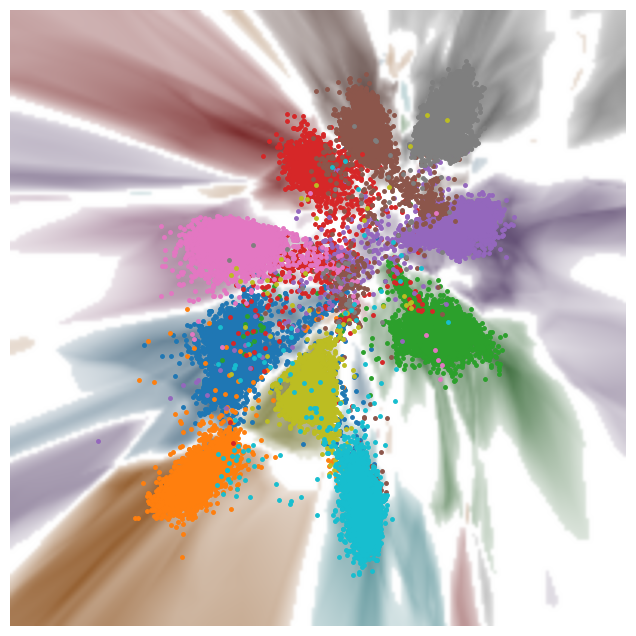

In [ ]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, ref_train_data, projector, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions1111 ...


UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U5')) -> None

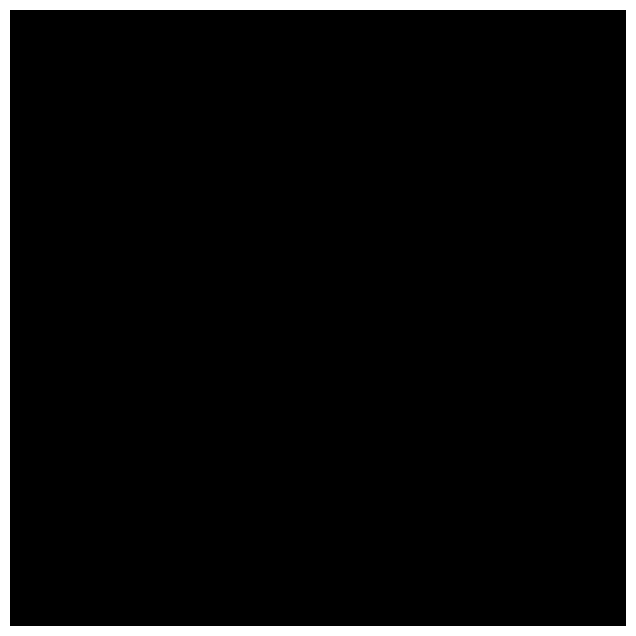

In [ ]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.hhhh_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(exchange_provider, np.dot(exchange_data,R), projector, 200, RT, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 25/25 [00:00<00:00, 13521.29it/s]


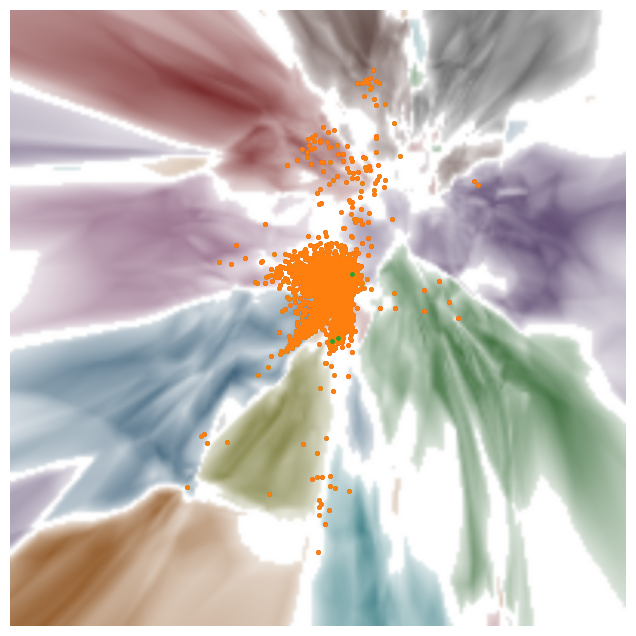

In [ ]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.r_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, confusion_provider.train_representation(200).squeeze(), projector, selected_indicated, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 25/25 [00:00<00:00, 13505.62it/s]


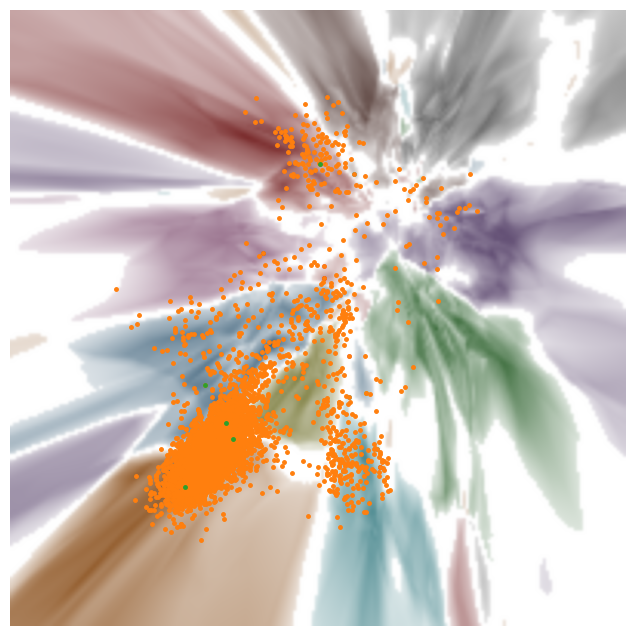

In [ ]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.r_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, np.dot(confusion_provider.train_representation(200).squeeze(),R), projector, selected_indicated, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.r_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(data_provider, train_data, projector, noisy_indicates, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.r_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(clean_data_provider, np.dot(noisy_data,R), projector, selected_indicated, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:

projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
CLEAN_2d = projector.batch_project(200, np.dot(noisy_data,R))
NOISY_2d = projector.batch_project(200, np.dot(noisy2500_data,R2500))
low = []
high = []

for i in range(len(CLEAN_2d)):
    d = ((CLEAN_2d[i][0] - NOISY_2d[i][0])**2 + (CLEAN_2d[i][1] - NOISY_2d[i][1])**2)**0.5
    if d < 5:
        low.append(i)
    else:
        high.append(i)


print(len(low),len(high))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 6261.65it/s]


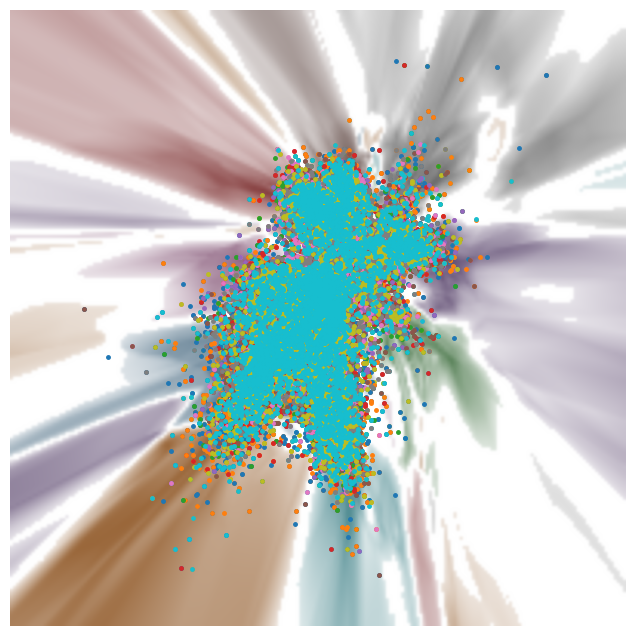

In [ ]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(data_provider,np.dot(noisy2500_data_provider.train_representation(1).squeeze(),R), projector, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(1, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.r_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(data_provider,data_provider.train_representation(10).squeeze(), projector, selected_indicated, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(10, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 50/50 [00:00<00:00, 13693.45it/s]


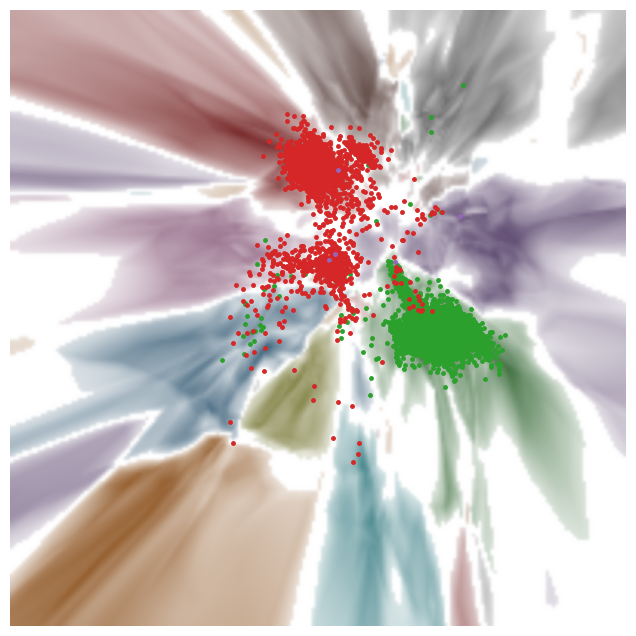

In [ ]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.r_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(data_provider,data_provider.train_representation(200).squeeze(), projector, selected_indicated, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 50/50 [00:00<00:00, 12822.70it/s]


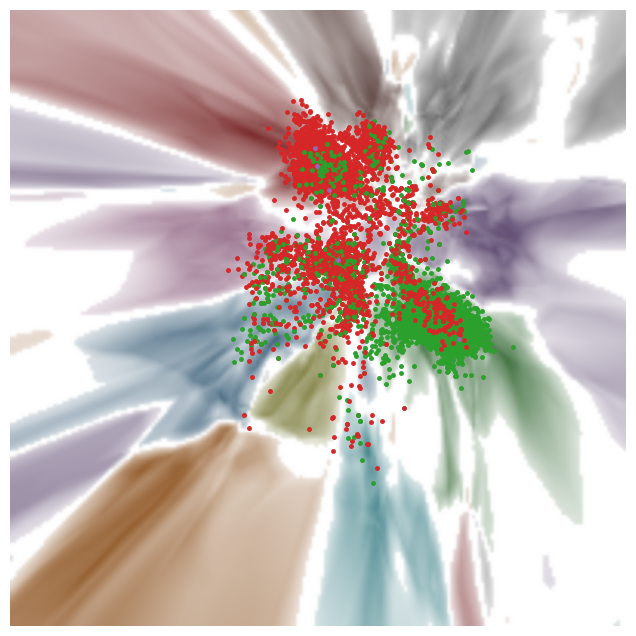

In [ ]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.r_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(data_provider,np.dot(noisy2500_data_provider.train_representation(200).squeeze(),R), projector, selected_indicated, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 50/50 [00:00<00:00, 13131.82it/s]


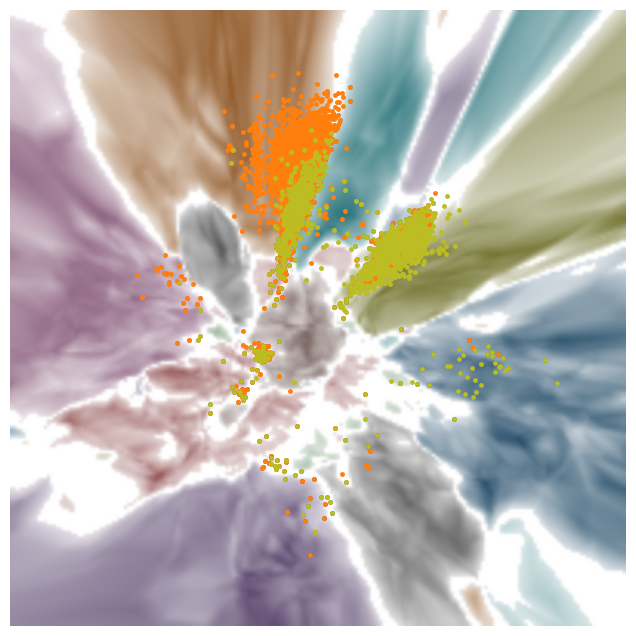

In [ ]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=NOISY2500, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.r_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(noisy2500_data_provider,noisy2500_data_provider.train_representation(10).squeeze(), projector, selected_indicated, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(10, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.r_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(noisy_data_provider, noisy_data, projector, selected_indicated, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))